In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import skfuzzy as fuzzy
import skfuzzy.control as ctrl

import paho.mqtt.client as mqtt

plt.rcParams['figure.figsize'] = [10, 8]

In [2]:
def make_pretty(xlabel, ylabel):
    for l in plt.gca().lines: l.set_linewidth(2)

    fig = plt.gcf()
    axes = fig.gca()
    fig.set_size_inches(6, 2)
    axes.set_xlabel(xlabel=xlabel)
    axes.set_ylabel(ylabel=ylabel)
    plt.legend(loc='upper right');

def make_ylim(lim):
    fig = plt.gcf()
    axes = fig.gca()
    axes.set_xlim(lim)

Cada andar tem 3 metros, exceto o terreo, que possui 4 metros. Dessa forma, o erro maximo é:

$$
4 + 3 \times (8 - 1) = 25
$$

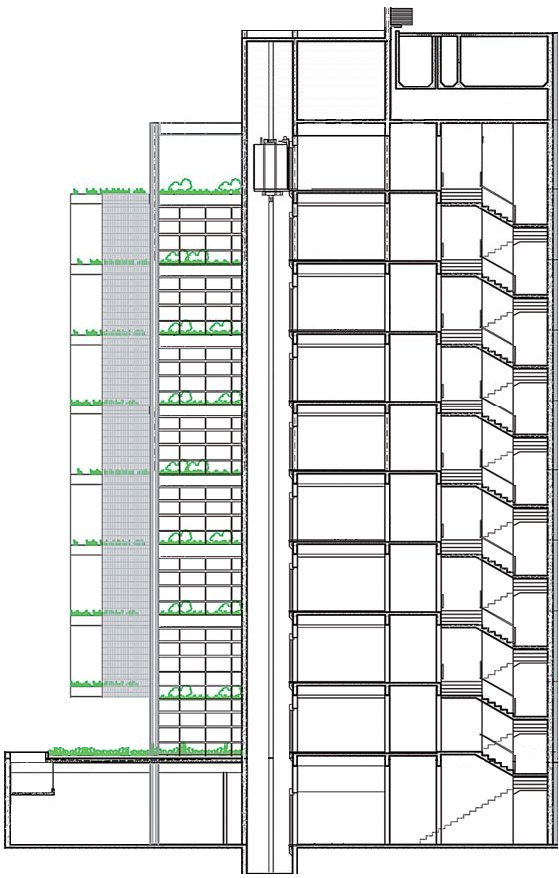

In [3]:
Error = ctrl.Antecedent(universe=np.arange(0, 25+0.1, 0.1), label='Error')

ZE = 'DistZero'
DC = 'DistClose'
DM = 'DistMedium'
DL = 'DistLarge'
DA = 'DistAway'

Error[ZE] = fuzzy.trapmf(Error.universe, [0, 0, 0.1, 0.2])
Error[DC] = fuzzy.trimf(Error.universe, [0.2, 4, 8])
Error[DM] = fuzzy.trimf(Error.universe, [4, 8, 12])
Error[DL] = fuzzy.trimf(Error.universe, [8, 12, 20])
Error[DA] = fuzzy.trapmf(Error.universe, [12, 20, 25, 25])

/home/upprsk/.pyenv/versions/3.11.9/envs/venv/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


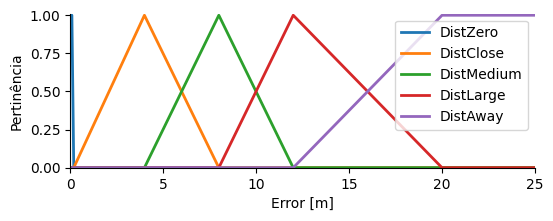

In [4]:
Error.view()
make_pretty('Error [m]', 'Pertinência')
make_ylim([0, 25])

In [5]:
DeltaError = ctrl.Antecedent(universe=np.arange(-25, 25+0.1, 0.1), label='DeltaError')

MN = 'VeryNegative'
PN = 'LittleNegative'
ZE = 'Zero'
PP = 'LittlePositive'
MP = 'VeryPositive'

DeltaError[MN] = fuzzy.trapmf(DeltaError.universe, [-25, -25, -2, -0.1])
DeltaError[PN] = fuzzy.trimf(DeltaError.universe, [-2, -0.1, 0])
DeltaError[ZE] = fuzzy.trimf(DeltaError.universe, [-0.1, 0, 0.1])
DeltaError[PP] = fuzzy.trimf(DeltaError.universe, [0, 0.1, 2])
DeltaError[MP] = fuzzy.trapmf(DeltaError.universe, [0.1, 2, 25, 25])

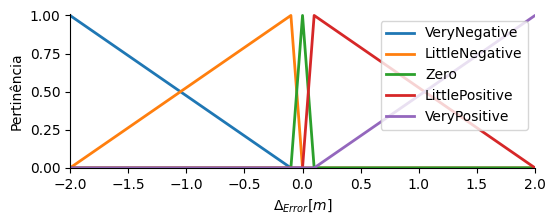

In [6]:
DeltaError.view()
make_pretty('$\Delta_{Error} [m]$', 'Pertinência')
make_ylim([-2, 2])

In [7]:
Power = ctrl.Consequent(universe=np.arange(0, 1.005, 0.005), label='Power')

IN = 'Initial'
SL = 'Slow'
MD = 'Medium'
FT = 'Fast'

# Power[IN] = fuzzy.trimf(Power.universe, [0, 0, 0.315])
# Power[SL] = fuzzy.trimf(Power.universe, [0.15, 0.45, 0.9])
# Power[MD] = fuzzy.trimf(Power.universe, [0.45, 0.9, 1])
# Power[FT] = fuzzy.trimf(Power.universe, [0.9, 1, 1])

Power[IN] = fuzzy.trimf(Power.universe, [0, 0, 0.315])
Power[SL] = fuzzy.trimf(Power.universe, [0.0, 0.3, 0.6])
Power[MD] = fuzzy.trimf(Power.universe, [0.3, 0.6, 1])
Power[FT] = fuzzy.trimf(Power.universe, [0.6, 1, 1])

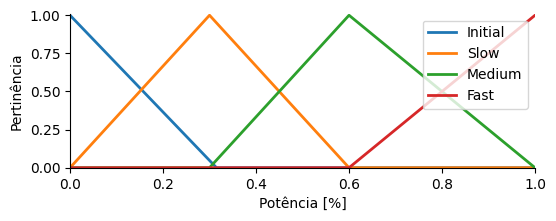

In [8]:
Power.view()
make_pretty('Potência [%]', 'Pertinência')

### Controle direto

- $e > 0$: acima
- $e < 0$: abaixo

### Controle reverso

- $e > 0$: abaixo
- $e < 0$: acima

|    | ZE | DC | DM | DL | DA |
| -- | -- | -- | -- | -- | -- |
| MN | IN | SL | MD | MD | FT |
| PN | IN | SL | SL | SL | MD |
| ZE | IN | IN | IN | IN | IN |
| PP | IN | SL | SL | SL | MD |
| MP | IN | SL | MD | MD | FT |

In [9]:
import itertools

results = [
    IN, IN, IN, IN, IN,
    SL, SL, IN, SL, SL,
    MD, SL, IN, SL, MD,
    MD, SL, IN, SL, MD,
    FT, MD, IN, MD, FT,
]

rules = [
    ctrl.Rule(Error[v] & DeltaError[i], Power[r])
    for (v, i), r in
    zip(itertools.product(Error.terms.keys(), DeltaError.terms.keys()), results)
]

rules

[IF Error[DistZero] AND DeltaError[VeryNegative] THEN Power[Initial]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF Error[DistZero] AND DeltaError[LittleNegative] THEN Power[Initial]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF Error[DistZero] AND DeltaError[Zero] THEN Power[Initial]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF Error[DistZero] AND DeltaError[LittlePositive] THEN Power[Initial]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF Error[DistZero] AND DeltaError[VeryPositive] THEN Power[Initial]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF Error[DistClose] AND DeltaError[VeryNegative] THEN Power[Slow]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF Error[DistClose] AND DeltaError[LittleNegative] THEN Power[Slow]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF Error[DistClose] AND DeltaError[Zero

In [10]:
import re

regex = re.compile(r"(:?\[([^\]]+)\])")
rulesstr = [[match for _, match in regex.findall(str(rule))] for rule in rules]

[f'{v} & {i} = {r}' for v, i, r in rulesstr]

['DistZero & VeryNegative = Initial',
 'DistZero & LittleNegative = Initial',
 'DistZero & Zero = Initial',
 'DistZero & LittlePositive = Initial',
 'DistZero & VeryPositive = Initial',
 'DistClose & VeryNegative = Slow',
 'DistClose & LittleNegative = Slow',
 'DistClose & Zero = Initial',
 'DistClose & LittlePositive = Slow',
 'DistClose & VeryPositive = Slow',
 'DistMedium & VeryNegative = Medium',
 'DistMedium & LittleNegative = Slow',
 'DistMedium & Zero = Initial',
 'DistMedium & LittlePositive = Slow',
 'DistMedium & VeryPositive = Medium',
 'DistLarge & VeryNegative = Medium',
 'DistLarge & LittleNegative = Slow',
 'DistLarge & Zero = Initial',
 'DistLarge & LittlePositive = Slow',
 'DistLarge & VeryPositive = Medium',
 'DistAway & VeryNegative = Fast',
 'DistAway & LittleNegative = Medium',
 'DistAway & Zero = Initial',
 'DistAway & LittlePositive = Medium',
 'DistAway & VeryPositive = Fast']

In [11]:
CtrlPower = ctrl.ControlSystemSimulation(ctrl.ControlSystem(rules))
CtrlPower

In [12]:
current_position = 7
set_point = 4

acceptable_error = 0.1

time = np.arange(0, 121, 1)

powers = [0]
positions = [current_position]
errors = [abs(set_point - current_position)]
delta_errors = [0]
speeds = [0]
accels = [0]

previous_error = abs(set_point - current_position)
previous_speed = 0

for t in time[1:]:
    raw_error = set_point - current_position
    current_error = abs(raw_error)
    current_delta_error = previous_error - current_error

    if t > 3:
        CtrlPower.input[Error.label] = current_error
        CtrlPower.input[DeltaError.label] = current_delta_error
        CtrlPower.compute()
        power = CtrlPower.output[Power.label]
    else:
        power = (t*0.315/3) / 100
    
    previous_position = current_position
    # if current_error >= acceptable_error:
    c = -1 if raw_error < 0 else 1
    current_position = abs(current_position*0.996*c + 100*power * 0.00951)
        
    previous_error = current_error

    speed = current_position - previous_position # speed m/s
    accel = speed - previous_speed # acceleration m/s^2
    previous_speed = speed
    
    positions.append(current_position)
    powers.append(power)
    errors.append(current_error)
    delta_errors.append(current_delta_error)
    speeds.append(speed)
    accels.append(accel)

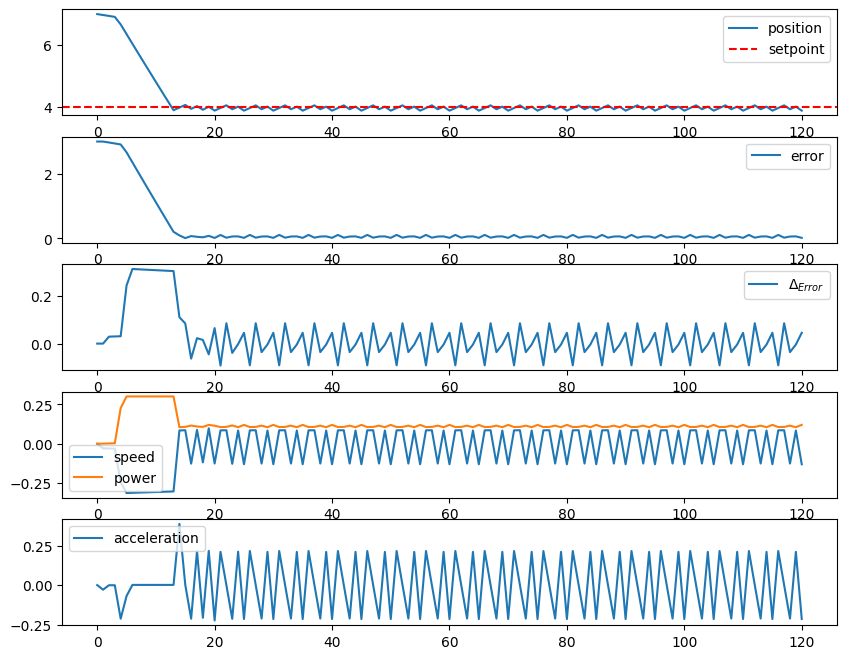

In [13]:
plt.subplots(5, 1)

plt.subplot(5, 1, 1)
plt.plot(time, positions, label='position')
plt.axhline(set_point, color='r', linestyle='--', label='setpoint')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(time, errors, label='error')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(time, delta_errors, label='$\Delta_{Error}$')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(time, speeds, label='speed')
plt.plot(time, powers, label='power')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(time, accels, label='acceleration')
plt.legend()

In [14]:
mqttBroker = "test.mosquitto.org"
client = mqtt.Client(mqtt.CallbackAPIVersion.VERSION1, f'python-mqtt-{random.randint(0, 1000)}')
client.connect(mqttBroker)

/tmp/ipykernel_332759/3251757459.py:2: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client(mqtt.CallbackAPIVersion.VERSION1, f'python-mqtt-{random.randint(0, 1000)}')


<MQTTErrorCode.MQTT_ERR_SUCCESS: 0>

In [ ]:
import time

class App:
    def __init__(self, ctrl, client):
        self.ctrl = ctrl

        self.client = client
        self.client.subscribe('oh_no/what_have_i_done/set_point/force')
        self.client.on_message = self.on_message

        self.acceptable_error = 0.1
        self.time_running = 0

        self.set_point = 4
        self.current_position = 4

    def on_message(self, client, userdata, msg):
        # print(msg.payload, msg.topic)
        
        if msg.topic == 'oh_no/what_have_i_done/set_point/force':
            self.set_point = int(msg.payload)
            self.time_running = 0

    def run(self):
        print('running')
        while True:
            self.step()

            self.client.publish('oh_no/what_have_i_done/position', self.current_position)
            self.client.publish('oh_no/what_have_i_done/set_point', self.set_point)
            print(self.time_running, '::', self.current_position, '->', self.set_point, end='\t\r')

            self.client.loop()
            self.time_running += 1
            time.sleep(1)

    def step(self):
        raw_error = self.set_point - self.current_position
        current_error = abs(raw_error)
        current_delta_error = previous_error - current_error
        
        # if current_error < self.acceptable_error:
        #     return

        if self.time_running <= 3:
            power = (self.time_running*0.315/3) / 100
        else:
            self.ctrl.input[Error.label] = current_error
            self.ctrl.input[DeltaError.label] = current_delta_error
            self.ctrl.compute()
            power = self.ctrl.output[Power.label]

            c = -1 if raw_error < 0 else 1
            self.current_position = abs(self.current_position*0.996*c + 100*power * 0.00951)

        self.client.publish('oh_no/what_have_i_done/power', power)
            

app = App(CtrlPower, client)
app.run()

running
